In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data"

In [212]:
# Rephrase
experiment = "identity_counterfactual"
include_completion=True

dfs = [
    # ("GPT2 Truthful", pd.read_pickle(f"{data_dir}/full/results_718028_gpt2_truthful.pkl")),
    (
        "Llama-2",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_718535_llama-awq_truthful.pkl"),
    ),
    (
        "Llama-2",
        "Trivia",
        pd.read_pickle(f"{data_dir}/full/results_718695_llama-awq_trivia.pkl"),
    ),
    (
        "Llama-3.1",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_718860_llama-3.1-8b_4bit_truthful.pkl"),
    ),
    (
        "Llama-3.1",
        "Trivia",
        pd.read_pickle(f"{data_dir}/full/results_718862_llama-3.1-8b_4bit_trivia.pkl"),
    ),
    (
        "Llama-3.2",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_12479_llama-3.2-3b_4bit_rephrase_truthful.pkl"),
    ),
    (
        "Llama-3.2",
        "Trivia",
        pd.read_pickle(f"{data_dir}/full/results_9927_llama-3.2-3b_4bit_rephrase_trivia.pkl"),
    ),
    (
        "phi-4",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_719053_phi4_4bit_truthful.pkl"),
    ),
    (
        "phi-4",
        "Trivia",
        pd.read_pickle(f"{data_dir}/full/results_719462_phi4_4bit_trivia.pkl"),
    ),
]

In [199]:
# Rephrase, Synonym and Random
experiment = "llama_3.2_counterfactuals"
include_completion = False

dfs = [
    (
        "Rephrase",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_7361_llama-3.2-3b_4bit_rephrase_medium_truthful.pkl"),
    ),
    (
        "Synonym",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_8807_llama-3.2-3b_4bit_synonym_truthful.pkl"),
    ),
    (
        "Random",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_8808_llama-3.2-3b_4bit_random_truthful.pkl"),
    ),
]

In [186]:
# Rephrase low-medium-high
experiment = "llama_3.2_rephrase_divergences"
include_completion = False

dfs = [
    (
        "Low",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_7360_llama-3.2-3b_4bit_rephrase_low_truthful.pkl"),
    ),
    (
        "Medium",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_7361_llama-3.2-3b_4bit_rephrase_medium_truthful.pkl"),
    ),
    (
        "High",
        "Truthful",
        pd.read_pickle(f"{data_dir}/full/results_7362_llama-3.2-3b_4bit_rephrase_high_truthful.pkl"),
    ),
]

In [213]:
for name, dataset, df in dfs:
    df.drop(
        df[df["completion_length"] == 0].index, inplace=True
    )

In [214]:
for name, dataset, df in dfs:
    print(f"{name:<15} {dataset:<15} accuracy: {sum(df["evaluation"]) / len(df)}")

Llama-2         Truthful        accuracy: 0.33579335793357934
Llama-2         Trivia          accuracy: 0.6364095442494635
Llama-3.1       Truthful        accuracy: 0.21509433962264152
Llama-3.1       Trivia          accuracy: 0.5526672082317898
Llama-3.2       Truthful        accuracy: 0.17063989962358847
Llama-3.2       Trivia          accuracy: 0.4474000802031814
phi-4           Truthful        accuracy: 0.3170731707317073
phi-4           Trivia          accuracy: 0.7525267993874426


In [215]:
for _, __, df in dfs:
    df["rephrased_gradient_mean"] = df["rephrased_gradients"].apply(
        lambda x: np.mean(x)
    )

    bins = 100


    df["completion_gradient"] = df["completion_gradient"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["completion_gradient_bins"] = pd.cut(
        df["completion_gradient"], bins=bins, labels=False
    )

    df["rephrased_gradient_mean"] = df["rephrased_gradient_mean"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["rephrased_gradient_mean_bins"] = pd.cut(
        df["rephrased_gradient_mean"], bins=bins, labels=False
    )

/Users/nilsgrunefeld/Documents/GitHub/gradient-uncertainty/env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nilsgrunefeld/Documents/GitHub/gradient-uncertainty/env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [216]:
def plot_gradients(
    dfs,
    experiment: str,
    include_completion: bool = True,
    save_dir: str = "../figures/qa",
    grid_figsize_per_plot: tuple = (4, 6),
    single_figsize: tuple = (4, 3),
):
    os.makedirs(save_dir, exist_ok=True)

    def _alias_xticks(ax):
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Incorrectly\nAnswered", "Correctly\nAnswered"])

    rows = []
    if include_completion:
        rows.append(("completion_box", lambda df, ax: (
            sns.boxplot(data=df, x="evaluation", y="completion_gradient", ax=ax),
            ax.set_yscale("log"),
            _alias_xticks(ax)
        )))
    rows.append(("rephrased_box", lambda df, ax: (
        sns.boxplot(data=df, x="evaluation", y="rephrased_gradient_mean", ax=ax),
        ax.set_yscale("log"),
        _alias_xticks(ax)
    )))

    if include_completion:
        rows.append(("completion_logistic", lambda df, ax:
            sns.regplot(data=df, x="completion_gradient", y="evaluation", logistic=True, ax=ax)
        ))
    rows.append(("rephrased_logistic", lambda df, ax:
        sns.regplot(data=df, x="rephrased_gradient_mean", y="evaluation", logistic=True, ax=ax)
    ))

    if include_completion:
        rows.append(("completion_bins", lambda df, ax: _plot_binned(df, "completion_gradient_bins", ax)))
    rows.append(("rephrased_bins", lambda df, ax: _plot_binned(df, "rephrased_gradient_mean_bins", ax)))

    n_rows = len(rows)
    n_cols = len(dfs)

    fig_grid, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(grid_figsize_per_plot[0] * n_cols, grid_figsize_per_plot[1] * n_rows),
        squeeze=False
    )

    for col_idx, (model, dataset, df) in enumerate(dfs):
        model_dir = os.path.join(save_dir, experiment, dataset, model)
        os.makedirs(model_dir, exist_ok=True)

        for row_idx, (metric_key, plot_fn) in enumerate(rows):
            ax_grid = axs[row_idx][col_idx]
            plot_fn(df, ax_grid)
            ax_grid.set_title(model)

            fig_sub, ax_sub = plt.subplots(figsize=single_figsize, dpi=300)
            plot_fn(df, ax_sub)
            ax_sub.set_xlabel("")
            ax_sub.set_ylabel("")
            if ax_sub.get_legend():
                ax_sub.legend_.remove()
            fig_sub.tight_layout()
            fig_sub.savefig(
                os.path.join(model_dir, f"{metric_key}.png"),
                transparent=True
            )
            plt.close(fig_sub)

    plt.tight_layout()
    plt.show()


def _plot_binned(df, bin_col, ax):
    grp = (
        df
        .groupby(bin_col)
        .agg(mean_evaluation=("evaluation", "mean"),
             row_count=("evaluation", "size"))
        .reset_index()
    )
    sns.scatterplot(
        data=grp,
        x=bin_col,
        y="mean_evaluation",
        size="row_count",
        ax=ax,
    )
    sns.regplot(
        data=grp,
        x=bin_col,
        y="mean_evaluation",
        scatter=False,
        line_kws={"ls": "--"},
        ax=ax,
    )


def compute_odds_ratios(
    dfs,
    include_completion: bool = True
):
    for name, dataset, df in dfs:
        if include_completion:
            data = df[["completion_gradient", "evaluation"]].dropna()
            X = sm.add_constant(data["completion_gradient"])
            y = data["evaluation"].astype(int)
            model = sm.Logit(y, X).fit(disp=0)
            or_c = np.exp(model.params["completion_gradient"])
            p_c = model.pvalues["completion_gradient"]
            print(f"{name:<20} {dataset:<20} Odds Ratio (completion_gradient): {or_c:.4f}, P-value: {p_c:.4f}")

        data = df[["rephrased_gradient_mean", "evaluation"]].dropna()
        X = sm.add_constant(data["rephrased_gradient_mean"])
        y = data["evaluation"].astype(int)
        model = sm.Logit(y, X).fit(disp=0)
        or_r = np.exp(model.params["rephrased_gradient_mean"])
        p_r = model.pvalues["rephrased_gradient_mean"]
        print(f"{name:<20} {dataset:<20} Odds Ratio (rephrased_gradient_mean): {or_r:.4f}, P-value: {p_r:.4f}")


def perform_t_tests(
    dfs,
    include_completion: bool = True
):
    for name, dataset, df in dfs:
        if include_completion:
            true_c = df[df["evaluation"] == True]["completion_gradient"].dropna()
            false_c = df[df["evaluation"] == False]["completion_gradient"].dropna()
            t_c, p_c = ttest_ind(true_c, false_c, equal_var=False)
            print(f"{name:<20} {dataset:<20} T-statistic (completion_gradient): {t_c:>12.4f}, P-value: {p_c:.4f}")

        true_r = df[df["evaluation"] == True]["rephrased_gradient_mean"].dropna()
        false_r = df[df["evaluation"] == False]["rephrased_gradient_mean"].dropna()
        t_r, p_r = ttest_ind(true_r, false_r, equal_var=False)
        print(f"{name:<20} {dataset:<20} T-statistic (rephrased_gradient_mean): {t_r:>12.4f}, P-value: {p_r:.4f}")


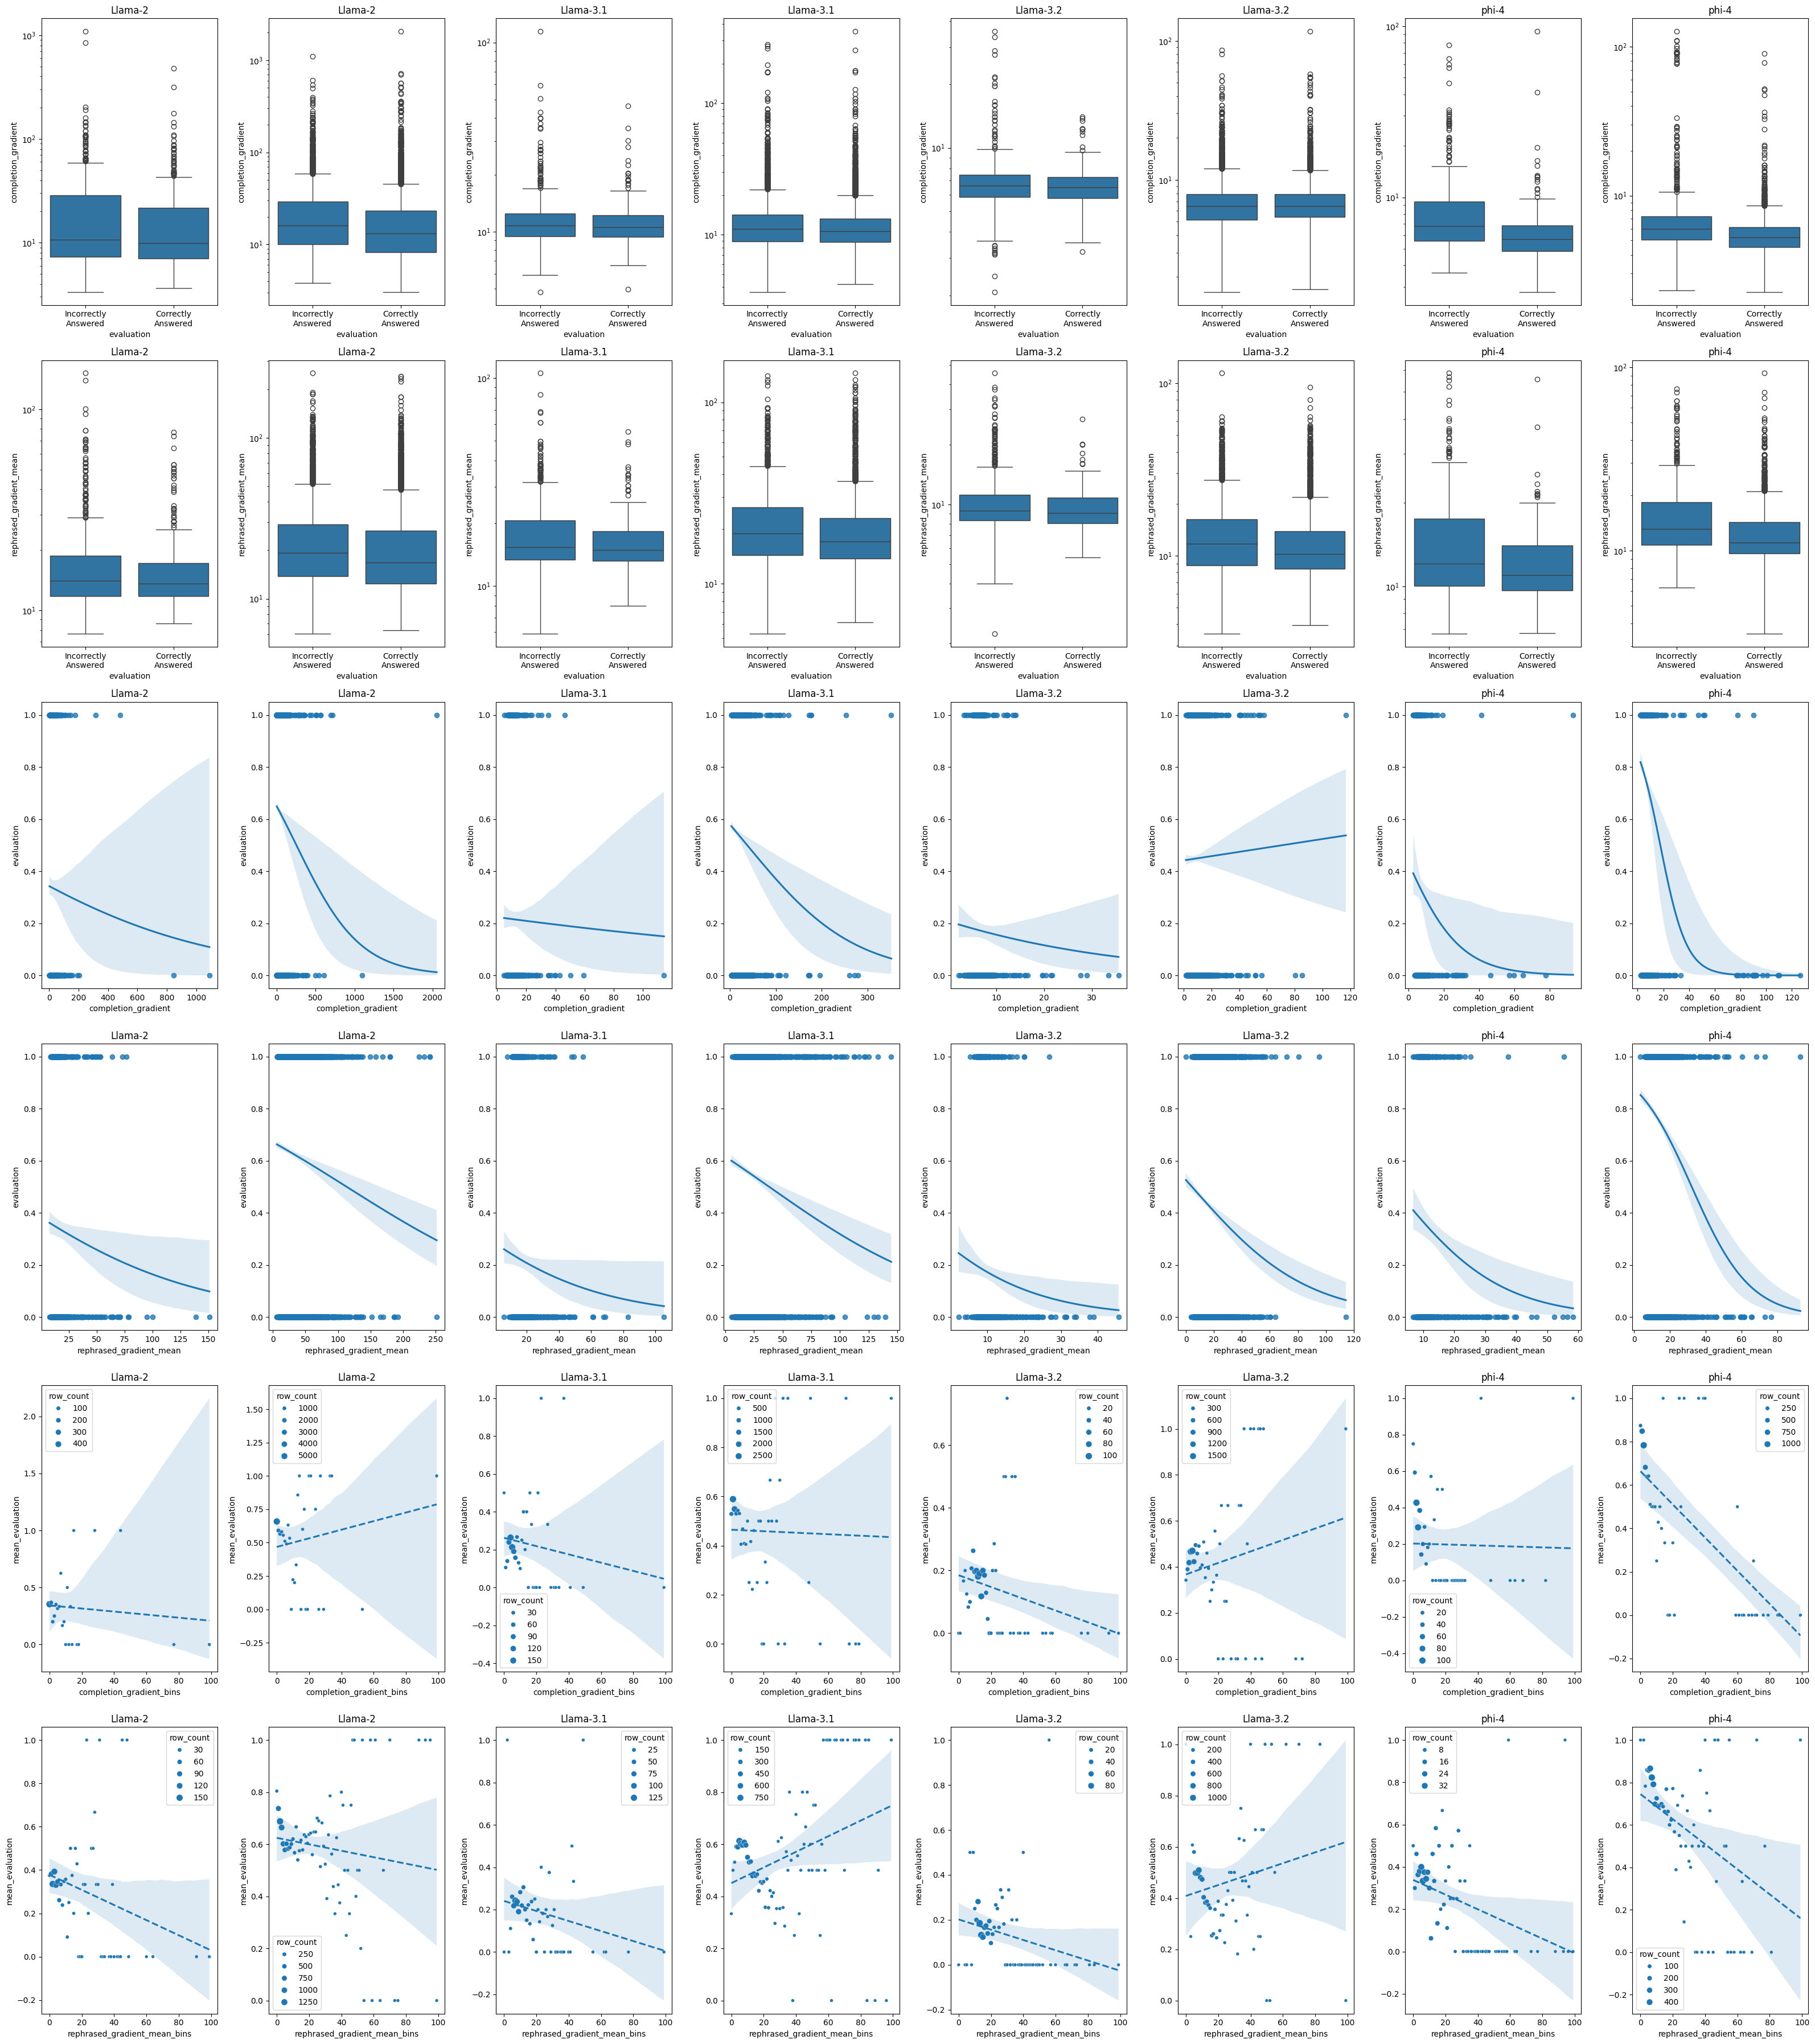

In [217]:
plot_gradients(dfs, experiment=experiment, include_completion=include_completion)

In [218]:
perform_t_tests(dfs, include_completion=include_completion)

Llama-2              Truthful             T-statistic (completion_gradient):      -0.9590, P-value: 0.3379
Llama-2              Truthful             T-statistic (rephrased_gradient_mean):      -2.0046, P-value: 0.0454
Llama-2              Trivia               T-statistic (completion_gradient):      -4.2672, P-value: 0.0000
Llama-2              Trivia               T-statistic (rephrased_gradient_mean):      -5.4124, P-value: 0.0000
Llama-3.1            Truthful             T-statistic (completion_gradient):      -0.3347, P-value: 0.7381
Llama-3.1            Truthful             T-statistic (rephrased_gradient_mean):      -2.0962, P-value: 0.0368
Llama-3.1            Trivia               T-statistic (completion_gradient):      -3.9410, P-value: 0.0001
Llama-3.1            Trivia               T-statistic (rephrased_gradient_mean):      -6.1362, P-value: 0.0000
Llama-3.2            Truthful             T-statistic (completion_gradient):      -1.0885, P-value: 0.2773
Llama-3.2            

In [219]:
compute_odds_ratios(dfs, include_completion=include_completion)

Llama-2              Truthful             Odds Ratio (completion_gradient): 0.9987, P-value: 0.4174
Llama-2              Truthful             Odds Ratio (rephrased_gradient_mean): 0.9886, P-value: 0.0782
Llama-2              Trivia               Odds Ratio (completion_gradient): 0.9976, P-value: 0.0001
Llama-2              Trivia               Odds Ratio (rephrased_gradient_mean): 0.9937, P-value: 0.0000
Llama-3.1            Truthful             Odds Ratio (completion_gradient): 0.9957, P-value: 0.7756
Llama-3.1            Truthful             Odds Ratio (rephrased_gradient_mean): 0.9793, P-value: 0.0743
Llama-3.1            Trivia               Odds Ratio (completion_gradient): 0.9915, P-value: 0.0002
Llama-3.1            Trivia               Odds Ratio (rephrased_gradient_mean): 0.9878, P-value: 0.0000
Llama-3.2            Truthful             Odds Ratio (completion_gradient): 0.9661, P-value: 0.4055
Llama-3.2            Truthful             Odds Ratio (rephrased_gradient_mean): 0.94